In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
import torch as t
from torch import nn, Tensor
from torch.distributions.categorical import Categorical
from torch.nn import functional as F
from dataclasses import dataclass
import numpy as np
import einops
from jaxtyping import Float, Int
from typing import Optional, Callable, Union, List, Tuple
from functools import partial
from tqdm.notebook import tqdm
from dataclasses import dataclass
from rich import print as rprint
from rich.table import Table
from IPython.display import display, HTML
from pathlib import Path

In [2]:
import sys
# Make sure exercises are in the path
exercises_dir = Path("./exercises").resolve()
section_dir = (exercises_dir / "part4_superposition_and_saes").resolve()
if str(exercises_dir) not in sys.path: sys.path.append(str(exercises_dir))

from plotly_utils import imshow, line, hist
from part4_superposition_and_saes.utils import (
    plot_features_in_2d,
    plot_features_in_Nd,
    plot_features_in_Nd_discrete,
    plot_correlated_features,
    plot_feature_geometry,
    frac_active_line_plot,
)
import part4_superposition_and_saes.tests as tests
import part4_superposition_and_saes.solutions as solutions

if t.backends.mps.is_available():
    print("current PyTorch install was "
              "built with MPS enabled.")
    if t.backends.mps.is_built():
        print("MPS is available")
        device = t.device("mps")
else:
    device = t.device("cuda" if t.cuda.is_available() else "cpu")

MAIN = __name__ == "__main__"

current PyTorch install was built with MPS enabled.
MPS is available


/Users/daniellee/Library/Caches/pypoetry/virtualenvs/toy-hierarchy-NsY2iPjH-py3.12/lib/python3.12/site-packages/accelerate/utils/imports.py:282: UserWarning: `ACCELERATE_DISABLE_RICH` is deprecated and will be removed in v0.22.0 and deactivated by default. Please use `ACCELERATE_ENABLE_RICH` if you wish to use `rich`.
  warnings.warn(


current PyTorch install was built with MPS enabled.
MPS is available


# TMH: Superposition in a Nonprivileged Basis

## Define Model

In [6]:
def linear_lr(step, steps):
    return (1 - (step / steps))

def constant_lr(*_):
    return 1.0

def cosine_decay_lr(step, steps):
    return np.cos(0.5 * np.pi * step / (steps - 1))


@dataclass
class Config:
    # We optimize n_instances models in a single training loop to let us sweep over
    # sparsity or importance curves  efficiently. You should treat `n_instances` as
    # kinda like a batch dimension, but one which is built into our training setup.
    n_instances: int
    n_features: int = 6
    tree_depth: int = 2
    branching_factor: int = 2
    n_hidden: int = 2
    n_correlated_pairs: int = 0
    n_anticorrelated_pairs: int = 0

class Model(nn.Module):
    W: Float[Tensor, "n_instances n_hidden n_features"]
    b_final: Float[Tensor, "n_instances n_features"]
    # Our linear map is x -> ReLU(W.T @ W @ x + b_final)

    def __init__(
        self,
        cfg: Config,
        feature_probability: Optional[Union[float, Tensor]] = None,
        importance: Optional[Union[float, Tensor]] = None,
        device = device,
    ):
        super().__init__()
        self.cfg = cfg

        if feature_probability is None: feature_probability = t.ones(())
        if isinstance(feature_probability, float): feature_probability = t.tensor(feature_probability)
        self.feature_probability = feature_probability.to(device).broadcast_to((cfg.n_instances, cfg.n_features))
        if importance is None: importance = t.ones(())
        if isinstance(importance, float): importance = t.tensor(importance)
        self.importance = importance.to(device).broadcast_to((cfg.n_instances, cfg.n_features))

        self.W = nn.Parameter(nn.init.xavier_normal_(t.empty((cfg.n_instances, cfg.n_hidden, cfg.n_features))))
        self.b_final = nn.Parameter(t.zeros((cfg.n_instances, cfg.n_features)))
        self.to(device)

        self.device = device


    def forward(
        self,
        features: Float[Tensor, "... instances features"]
    ) -> Float[Tensor, "... instances features"]:
        hidden = einops.einsum(
           features, self.W,
           "... instances features, instances hidden features -> ... instances hidden"
        )
        out = einops.einsum(
            hidden, self.W,
            "... instances hidden, instances hidden features -> ... instances features"
        )
        return F.relu(out + self.b_final)


    def generate_batch(self, batch_size) -> Float[Tensor, "batch_size instances features"]:
        '''
        Generates a batch of data. We'll return to this function later when we apply correlations.
        '''
        pass # See below for solutions


    def calculate_loss(
        self,
        out: Float[Tensor, "batch instances features"],
        batch: Float[Tensor, "batch instances features"],
    ) -> Float[Tensor, ""]:
        '''
        Calculates the loss for a given batch, using this loss described in the Toy Models paper:

            https://transformer-circuits.pub/2022/toy_model/index.html#demonstrating-setup-loss

        Remember, `model.importance` will always have shape (n_instances, n_features).
        '''
        pass # See below for solutions


    def optimize(
        self,
        batch_size: int = 1024,
        steps: int = 10_000,
        log_freq: int = 100,
        lr: float = 1e-3,
        lr_scale: Callable[[int, int], float] = constant_lr,
    ):
        '''
        Optimizes the model using the given hyperparameters.
        '''
        optimizer = t.optim.Adam(list(self.parameters()), lr=lr)

        progress_bar = tqdm(range(steps))

        for step in progress_bar:

            # Update learning rate
            step_lr = lr * lr_scale(step, steps)
            for group in optimizer.param_groups:
                group['lr'] = step_lr

            # Optimize
            optimizer.zero_grad()
            batch = self.generate_batch(batch_size)
            out = self(batch)
            loss = self.calculate_loss(out, batch)
            loss.backward()
            optimizer.step()

            # Display progress bar
            if step % log_freq == 0 or (step + 1 == steps):
                progress_bar.set_postfix(loss=loss.item()/self.cfg.n_instances, lr=step_lr)


tests.test_model(Model)

All tests in `test_model` passed!


In [7]:
def generate_batch(self: Model, batch_size) -> Float[Tensor, "batch_size instances features"]:
    '''
    Generates a batch of data. We'll return to this function later when we apply correlations.
    '''

    n_features = self.cfg.branching_factor ** (self.cfg.tree_depth + 1) - 1

    feat = t.zeros((batch_size, self.cfg.n_instances, n_features))

    rand_shape = (batch_size, self.cfg.n_instances)

    for level in range(self.cfg.tree_depth+1):
        if level == 0:
            feat[:, :, 0] = (t.ones(rand_shape))
            continue

        start_idx = 2**(level) - 1

        for i in range(2**(level-1)):
            feat[:, :, start_idx + 2*i] = (t.rand(rand_shape) > 0.5).to(t.int)
            feat[:, :, start_idx + 2*i + 1] = 1 - feat[:, :, start_idx + 2*i]

            # we need to zero out inactive features

            parent_idx = (start_idx + 2*i - 1) // 2

            feat[:, :, start_idx + 2*i] *= feat[:, :, parent_idx]
            feat[:, :, start_idx + 2*i + 1] *= feat[:, :, parent_idx]

    # shave off root
    feat = feat[:, :, 1:]

    feat = feat.to(self.device)

    return feat

In [8]:
Model.generate_batch = generate_batch

# tests.test_generate_batch(Model)

In [19]:
def calculate_loss(
    self: Model,
    out: Float[Tensor, "batch instances features"],
    batch: Float[Tensor, "batch instances features"],
) -> Float[Tensor, ""]:
    '''
    Calculates the loss for a given batch, using this loss described in the Toy Models paper:

        https://transformer-circuits.pub/2022/toy_model/index.html#demonstrating-setup-loss

    Remember, `self.importance` will always have shape (n_instances, n_features).
    '''
    error = self.importance * ((batch - out) ** 2)
    loss = einops.reduce(error, 'batch instances features -> instances', 'mean').sum()
    return loss

Model.calculate_loss = calculate_loss


## Tree of (2, *2)


### same importance

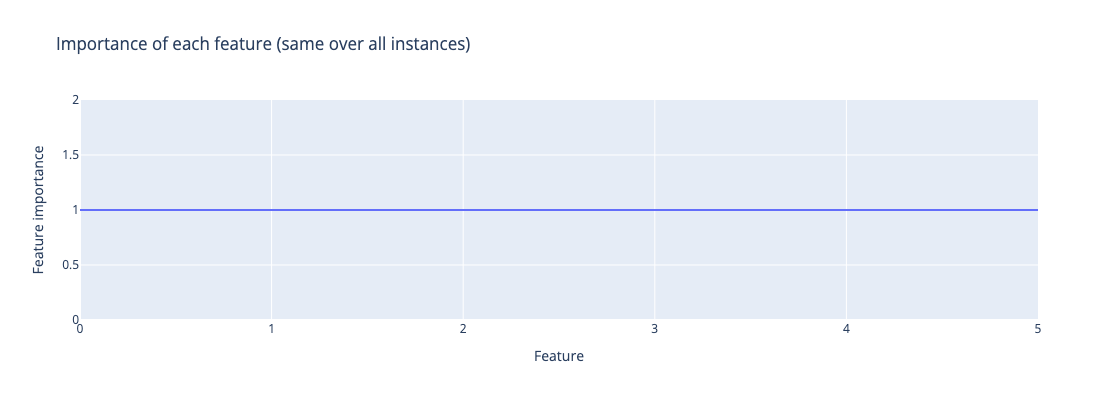

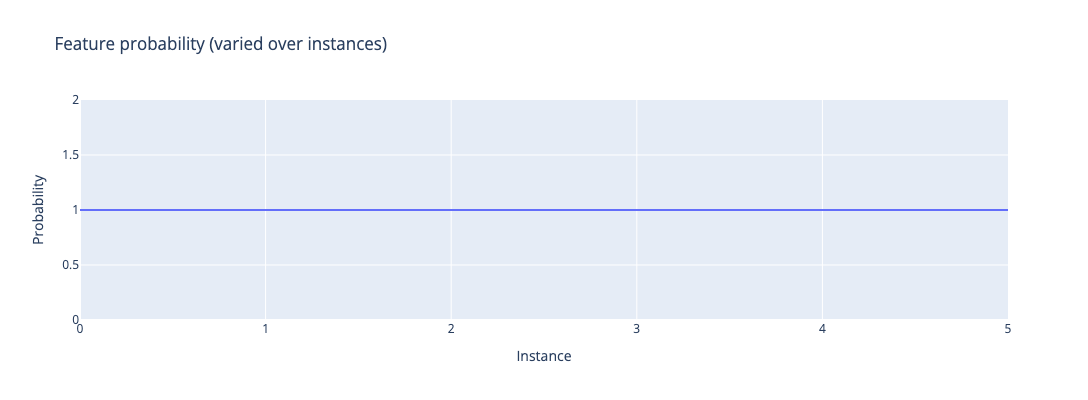

In [27]:
cfg = Config(
    n_instances = 6,
    n_features = 6,
    n_hidden = 2,
)

# importance varies within features for each instance
# importance = (0.9 ** t.arange(cfg.n_features))
importance = (1.0 ** t.arange(cfg.n_features))
importance = einops.rearrange(importance, "features -> () features")

# sparsity is the same for all features in a given instance, but varies over instances
feature_probability = (1 ** -t.linspace(0, 1, cfg.n_instances))
feature_probability = einops.rearrange(feature_probability, "instances -> instances ()")

line(importance.squeeze(), width=600, height=400, title="Importance of each feature (same over all instances)", labels={"y": "Feature importance", "x": "Feature"})
line(feature_probability.squeeze(), width=600, height=400, title="Feature probability (varied over instances)", labels={"y": "Probability", "x": "Instance"})

In [35]:
feature_probability.shape

torch.Size([6, 1])

In [28]:
model = Model(
    cfg = cfg,
    device = device,
    importance = importance,
    feature_probability = feature_probability,
)

  0%|          | 0/10000 [00:00<?, ?it/s]

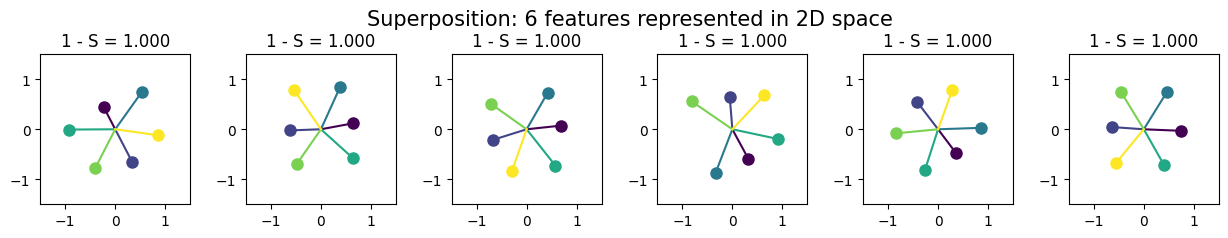

In [29]:
model.optimize(steps=10000)

plot_features_in_2d(
    model.W.detach(),
    colors = einops.repeat(t.arange((model.cfg.n_features)), 'n_features -> n_instances n_features', n_instances=model.cfg.n_instances) / 5,
    title = f"Superposition: {cfg.n_features} features represented in 2D space",
    subplot_titles = [f"1 - S = {i:.3f}" for i in feature_probability.squeeze()],
)

### Different Importance

In [61]:
importance = t.ones((cfg.n_instances, cfg.n_features))
importance[:, 0] = t.arange(0, cfg.n_instances)
importance[:, 1] = t.arange(0, cfg.n_instances)

t.pow(2, importance - 1)

tensor([[0.5000, 0.5000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [2.0000, 2.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [4.0000, 4.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [8.0000, 8.0000, 1.0000, 1.0000, 1.0000, 1.0000]])

  0%|          | 0/10000 [00:00<?, ?it/s]

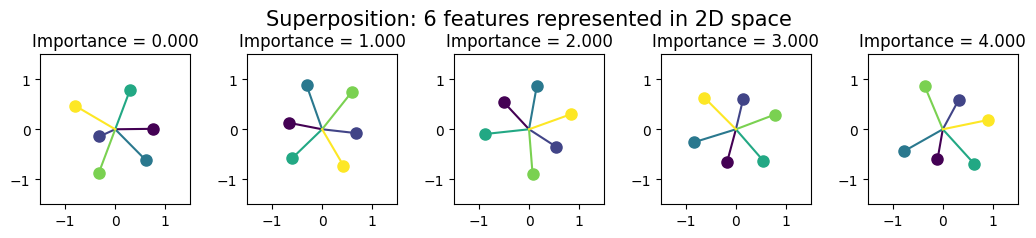

In [63]:
cfg = Config(
    n_instances = 5,
    n_features = 6,
    n_hidden = 2,
)

importance = t.ones((cfg.n_instances, cfg.n_features))
importance[:, 0] = t.arange(0, cfg.n_instances)
importance[:, 1] = t.arange(0, cfg.n_instances)
# importance = t.pow(2, importance - 1)

model = Model(
    cfg = cfg,
    device = device,
    importance = importance,
    feature_probability = None,
)

model.optimize(steps=10000)

plot_features_in_2d(
    model.W.detach(),
    colors = einops.repeat(t.arange((model.cfg.n_features)), 'n_features -> n_instances n_features', n_instances=model.cfg.n_instances) / 5,
    title = f"Superposition: {cfg.n_features} features represented in 2D space",
    subplot_titles = [f"Importance = {i:.3f}" for i in importance[:,0].squeeze()],
)

## More tree depth

### same importance

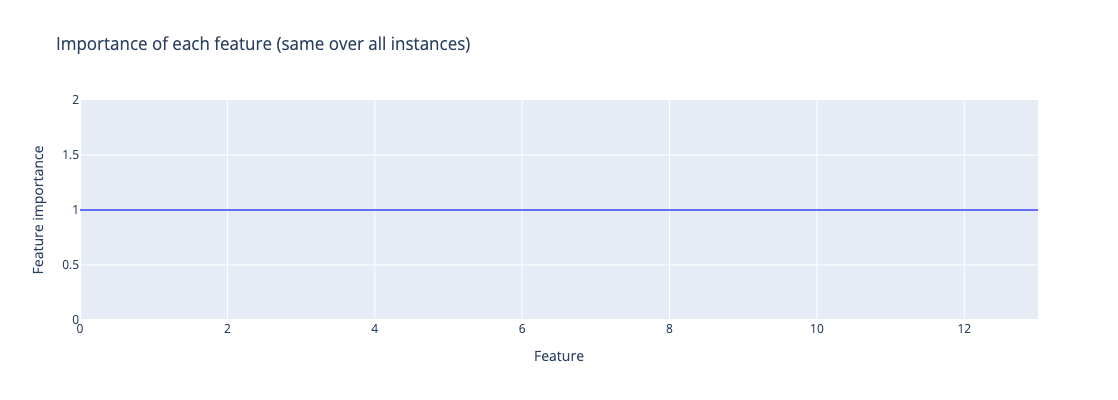

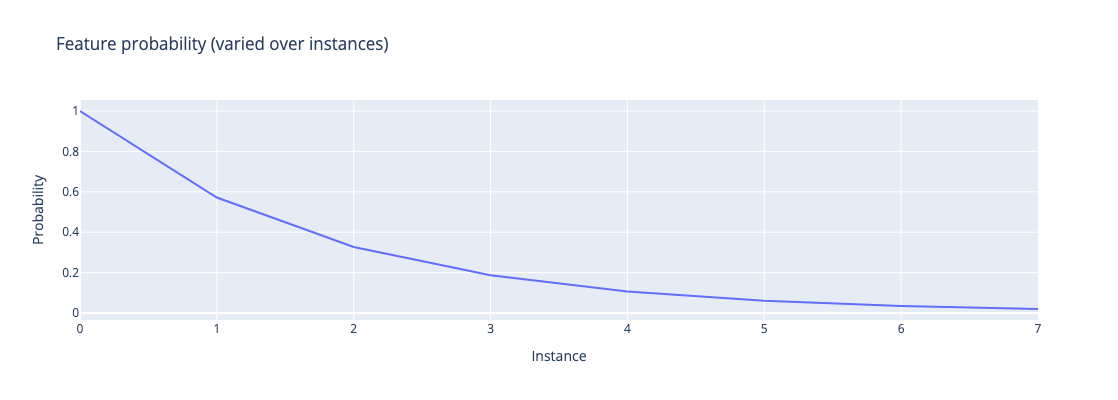

In [66]:
cfg = Config(
    n_instances = 8,
    n_features = 14,
    n_hidden = 2,
    branching_factor = 2,
    tree_depth = 3,
)


# importance varies within features for each instance
# importance = (0.9 ** t.arange(cfg.n_features))
importance = (1.0 ** t.arange(cfg.n_features))
importance = einops.rearrange(importance, "features -> () features")

# sparsity is the same for all features in a given instance, but varies over instances
feature_probability = (50 ** -t.linspace(0, 1, cfg.n_instances))
feature_probability = einops.rearrange(feature_probability, "instances -> instances ()")

line(importance.squeeze(), width=600, height=400, title="Importance of each feature (same over all instances)", labels={"y": "Feature importance", "x": "Feature"})
line(feature_probability.squeeze(), width=600, height=400, title="Feature probability (varied over instances)", labels={"y": "Probability", "x": "Instance"})

In [17]:
model = Model(
    cfg = cfg,
    device = device,
    importance = importance,
    feature_probability = feature_probability,
)

  0%|          | 0/10000 [00:00<?, ?it/s]

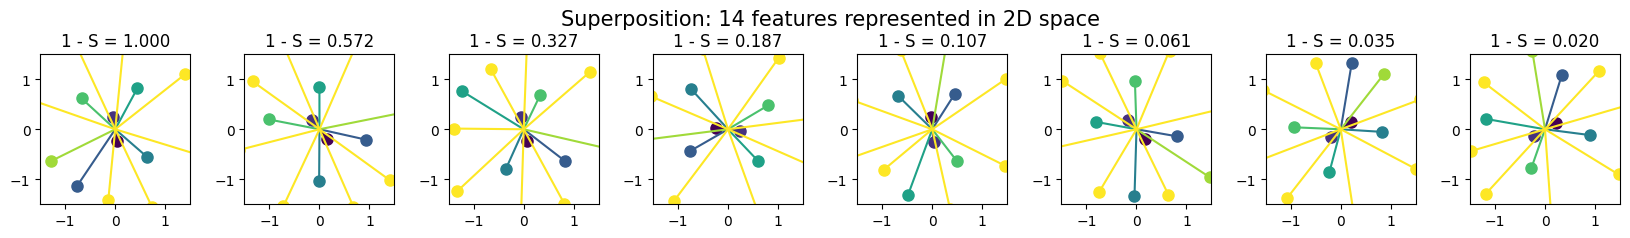

In [18]:
model.optimize(steps=10000)

plot_features_in_2d(
    model.W.detach(),
    colors = einops.repeat(t.arange((model.cfg.n_features)), 'n_features -> n_instances n_features', n_instances=model.cfg.n_instances) / (model.cfg.n_instances-1),
    title = f"Superposition: {cfg.n_features} features represented in 2D space",
    subplot_titles = [f"1 - S = {i:.3f}" for i in feature_probability.squeeze()],
)

### different importance

In [68]:
importance.shape

torch.Size([1, 14])

  0%|          | 0/10000 [00:00<?, ?it/s]

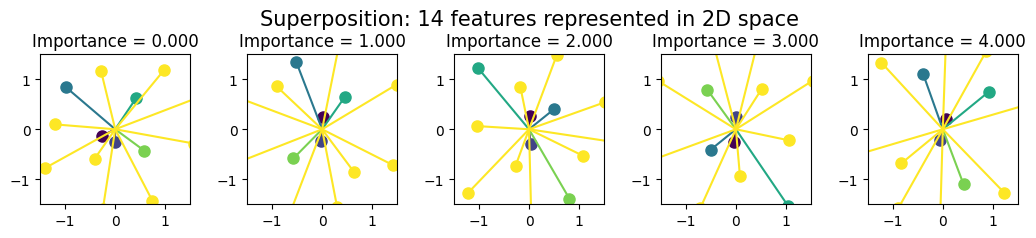

In [70]:
cfg = Config(
    n_instances = 5,
    n_features = 14,
    n_hidden = 2,
    branching_factor = 2,
    tree_depth = 3,
)

importance = t.ones((cfg.n_instances, cfg.n_features))
importance[:, 0] = t.arange(0, cfg.n_instances)
importance[:, 1] = t.arange(0, cfg.n_instances)
# importance = t.pow(2, importance - 1)

model = Model(
    cfg = cfg,
    device = device,
    importance = importance,
    feature_probability = None,
)



model.optimize(steps=10000)

plot_features_in_2d(
    model.W.detach(),
    colors = einops.repeat(t.arange((model.cfg.n_features)), 'n_features -> n_instances n_features', n_instances=model.cfg.n_instances) / 5,
    title = f"Superposition: {cfg.n_features} features represented in 2D space",
    subplot_titles = [f"Importance = {i:.3f}" for i in importance[:,0].squeeze()],
)